# Two port parameters
Last update: 26 Apr 2022  

Todo:  
- clean up narative
- spell check


In this post I describe the calculation of two port impedance parameters from the circuit's netlist. The first circuit is an antennuator, which could be easily analyized by hand with a pencil, paper and a calculator, but here I'm using python to step through the calculations. These same steps can be applied to larger, more complex circuits which would be difficult to analyze by hand. The second circuit is a bandpass filter. The Sympy and SciPy libraries can be used to obtain symbolic and numerical results, however as is shown below, when the circuit is large, symbolic results are not that useful nor do thay provid much insight.

Analyzing circuits is fundemental to electrical engineering. During my 40 year carer as an electrical engineer, the only two port parameters I used on a regular basis were s-parameters, I don't recall ever using the other types of two port parameters.

The procedure starts by first drawing a schematic of the circuit with a schematic capture program such as EasyEDA (links to the schematics are provided below) then the netlist is generated and exported as a text file. The netlist is used to generate modified nodal equations with the python program described [here](). The equations are solved for voltages and currents at the port terminals by using SymPy.

In [1]:
import numpy as np
from sympy import *
from scipy import signal
import matplotlib.pyplot as plt
init_printing()

## Pi-attenuator
The pi-attenuator is formed by three resistors with R1 and R3 as the shunt resistor values and R2 as the series resistor value in a circuit topology in the shape of the greek letter pi. For R1 = R3 = 96.25 ohms and R2 equal to 71.15 ohms, the attenuation is 10 dB and the port impedance is 50 ohms. Pasternack's Pi Attenuator Calculator ([Pi pad attenuator](https://www.pasternack.com/t-calculator-pi-attn.aspx)) was used to design the attenuator.

To find Z-parameters attach voltage sources to both ports and find the node equations. [EasyEDA](https://easyeda.com/) was used to draw the schematic and generate the netlist. A link to the schematic is [here](https://easyeda.com/editor#id=|6b1460bfe8ec4872b7d7fd3038f38331|82658727399e487c94ebe177746e0ba0).

![schematic](sch_pi_atten_10dB_50ohm.png)

The netlist:
~~~
R1 0 1 96.25
R2 1 2 71.15
R3 0 2 96.25
V1 1 0 1
V2 2 0 1
~~~

## Find z11 & z21

Remove V2 from net list and I2 should be zero. Operating with port 1 active.
~~~
*pi_atten_10dB_50ohm.net
R1 0 1 96.25
R2 1 2 71.15
R3 0 2 96.25
V1 1 0 1
*V2 2 0 1
~~~
The circuit equations generated by the MNA python code.
~~~
[[Eq(I_V1 + v1*(1/R2 + 1/R1) - v2/R2, 0)],
[Eq(v2*(1/R3 + 1/R2) - v1/R2, 0)],
[Eq(v1, V1)]]
~~~

In [2]:
# declare the following symbols
I_V1, R3, R2, V1, v1, R1, v2 = symbols('I_V1 R3 R2 V1 v1 R1 v2')

# use the equations generated by nodal analysis
equ_p1 = Matrix(
    [[Eq(I_V1 + v1*(1/R2 + 1/R1) - v2/R2, 0)],
    [Eq(v2*(1/R3 + 1/R2) - v1/R2, 0)],
    [Eq(v1, V1)]])
equ_p1

⎡          ⎛1    1 ⎞   v₂    ⎤
⎢I_V1 + v₁⋅⎜── + ──⎟ - ── = 0⎥
⎢          ⎝R₂   R₁⎠   R₂    ⎥
⎢                            ⎥
⎢      ⎛1    1 ⎞   v₁        ⎥
⎢   v₂⋅⎜── + ──⎟ - ── = 0    ⎥
⎢      ⎝R₃   R₂⎠   R₂        ⎥
⎢                            ⎥
⎣          v₁ = V₁           ⎦

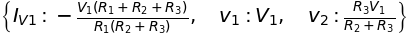

In [3]:
# find symbolic solution
u_p1 = solve(equ_p1,[v1, v2, I_V1])
u_p1

$z_{11} = \frac {V_1}{I_1} \text{  when  } I_2=0$  

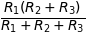

In [4]:
z11 = -u_p1[v1]/u_p1[I_V1]
z11

$z_{21} = \frac {V_2}{I_1} \text{  when  } I_2=0$  

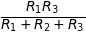

In [5]:
z21 = -u_p1[v2]/u_p1[I_V1]
z21

## Find z12 & z22
Remove V1 from net list.
~~~
*pi_atten_10dB_50ohm.net
R1 0 1 96.25
R2 1 2 71.15
R3 0 2 96.25
*V1 1 0 1
V2 2 0 1
~~~
The circuit equations generated by the MNA python code.
~~~
[[Eq(v1*(1/R2 + 1/R1) - v2/R2, 0)],
[Eq(I_V2 + v2*(1/R3 + 1/R2) - v1/R2, 0)],
[Eq(v2, V2)]]
~~~

In [6]:
# declare the following symbols
R3, R2, V2, v1, R1, I_V2, v2 = symbols('R3 R2 V2 v1 R1 I_V2 v2')

# use the equations generated by nodal analysis
equ_p2 = Matrix(
    [[Eq(v1*(1/R2 + 1/R1) - v2/R2, 0)],
    [Eq(I_V2 + v2*(1/R3 + 1/R2) - v1/R2, 0)],
    [Eq(v2, V2)]])
equ_p2

⎡      ⎛1    1 ⎞   v₂        ⎤
⎢   v₁⋅⎜── + ──⎟ - ── = 0    ⎥
⎢      ⎝R₂   R₁⎠   R₂        ⎥
⎢                            ⎥
⎢          ⎛1    1 ⎞   v₁    ⎥
⎢I_V2 + v₂⋅⎜── + ──⎟ - ── = 0⎥
⎢          ⎝R₃   R₂⎠   R₂    ⎥
⎢                            ⎥
⎣          v₂ = V₂           ⎦

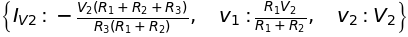

In [7]:
# find symbolic solution
u_p2 = solve(equ_p2,[v1, v2, I_V2])
u_p2

$z_{12} = \frac {V_1}{I_2} \text{  when  } I_1=0$ 

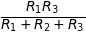

In [8]:
z12 = -u_p2[v1]/u_p2[I_V2]
z12

$z_{22} = \frac {V_2}{I_2} \text{  when  } I_1=0$  

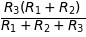

In [9]:
z22 = -u_p2[v2]/u_p2[I_V2]
z22

R1 = R3 = 96.25 ohms and R2 equal to 71.15 ohms

In [10]:
R1_val = 96.25
R2_val = 71.15
R3_val = R1_val

In [11]:
z11_val = z11.subs({R1:R1_val,R2:R2_val,R3:R3_val})
z12_val = z12.subs({R1:R1_val,R2:R2_val,R3:R3_val})
z21_val = z21.subs({R1:R1_val,R2:R2_val,R3:R3_val})
z22_val = z22.subs({R1:R1_val,R2:R2_val,R3:R3_val})

Z = np.array([[z11_val, z12_val],
               [z21_val, z22_val]],dtype=np.float)

det_z = np.linalg.det(Z)

In [12]:
Z

array([[61.11227005, 35.13772995],
       [35.13772995, 61.11227005]])

## Convert Z to S

Scattering parameters or S-parameters (the elements of a scattering matrix or S-matrix) describe the electrical behavior of linear electrical networks when undergoing various steady state stimuli by electrical signals.

The parameters are useful for several branches of electrical engineering, including electronics, communication systems design, and especially for microwave engineering.

The S-parameters are members of a family of similar parameters, other examples being: Y-parameters,[1] Z-parameters,[2] H-parameters, T-parameters or ABCD-parameters.[3][4] They differ from these, in the sense that S-parameters do not use open or short circuit conditions to characterize a linear electrical network; instead, matched loads are used. These terminations are much easier to use at high signal frequencies than open-circuit and short-circuit terminations. Contrary to popular belief, the quantities are not measured in terms of power (except in now-obsolete six-port network analyzers). Modern vector network analyzers measure amplitude and phase of voltage traveling wave phasors using essentially the same circuit as that used for the demodulation of digitally modulated wireless signals.

Many electrical properties of networks of components (inductors, capacitors, resistors) may be expressed using S-parameters, such as gain, return loss, voltage standing wave ratio (VSWR), reflection coefficient and amplifier stability. The term 'scattering' is more common to optical engineering than RF engineering, referring to the effect observed when a plane electromagnetic wave is incident on an obstruction or passes across dissimilar dielectric media. In the context of S-parameters, scattering refers to the way in which the traveling currents and voltages in a transmission line are affected when they meet a discontinuity caused by the insertion of a network into the transmission line. This is equivalent to the wave meeting an impedance differing from the line's characteristic impedance.

Although applicable at any frequency, S-parameters are mostly used for networks operating at radio frequency (RF) and microwave frequencies where signal power and energy considerations are more easily quantified than currents and voltages. S-parameters change with the measurement frequency, so frequency must be specified for any S-parameter measurements stated, in addition to the characteristic impedance or system impedance.

S-parameters are readily represented in matrix form and obey the rules of matrix algebra.


$s_{11} = \frac {(Z_{11}-Z_o)(Z_{22}+Z_o)-Z_{12}Z_{21}} {\Delta Z}$

$s_{12} = \frac {2Z_{12}Z_o} {\Delta Z}$

$s_{21} = \frac {2Z_{21}Z_o} {\Delta Z}$

$s_{22} = \frac {(Z_{11}+Z_o)(Z_{22}-Z_o)-Z_{12}Z_{21}} {\Delta Z}$

$\Delta Z = (Z_{11}+Z_o)(Z_{22}+Z_o)-Z_{12}Z_{21}$

The 2-port S-parameters have the following generic descriptions:  
$S_{11} \text{ is the input port voltage reflection coefficient}$  
$S_{12} \text{ is the reverse voltage gain}$  
$S_{21} \text{ is the forward voltage gain}$  
$S_{22} \text{ is the output port voltage reflection coefficient}$  



In [14]:
Z_o = 50 # characteristic impedance
del_z = (z11_val+Z_o)*(z22_val+Z_o)-z12_val*z21_val

S = np.array([[((z11_val-Z_o)*(z22_val-Z_o)-z12_val*z21_val)/del_z,(2*z12_val*Z_o)/del_z],
              [(2*z21_val*Z_o)/del_z,((z11_val+Z_o)*(z22_val-Z_o)-z12_val*z21_val)/del_z]],dtype=np.float)

In [15]:
S

array([[-1.00004488e-01,  3.16234863e-01],
       [ 3.16234863e-01,  4.45363654e-06]])

### Input return loss
Input return loss (RLin) indicates impedance match of the port to the source. A number of 10 dB or greater, indicates that the match is probably acceptable.

$RL_{in} =-20\log_{10}\left|S_{11}\right|$

In [16]:
print('Input return loss = {:.2f} dB'.format(-20*np.log10(np.abs(S[0,0]))))

Input return loss = 20.00 dB


### Insertion loss
Insertion loss (IL) is the reciprocal of the magnitude of the transmission coefficient, S21, expressed in decibels.

$IL=-20\log _{10} \left|S_{21} \right|$

In [17]:
print('Insertion loss = {:.2f}'.format(-20*np.log10(np.abs(S[1,0]))))

Insertion loss = 10.00


## Band Pass Filter
The circuit below is a band pass filter designed from normalized filter design tables. 

The Bessel filter is a linear phase filter and the low pass values for a 3rd order filter with equal termination resistors was selected for this example.


![schematic](BPF_10MHz.png)

The link to the schematic in EasyEDA is [here](https://easyeda.com/editor#mode=sim,id=|6b1460bfe8ec4872b7d7fd3038f38331|82658727399e487c94ebe177746e0ba0|ea67be55cc5c49f288edfa4ed837b1f0|8ea3b89798114238a453a1c678008c07|bef561e1caa74d498d621a82362fc683|3b000d947aad4568aba52d9cefa5715c).



fo = 10MHz
BW3dB = 1 MHz


~~~
3rd order Bessel LPF prototype <<<<  doesnt work
Rs/Rl = 1
C1 = 0.3374
L2 = 0.9705
C1 = 2.2034

3rd order Butterworth LPF prototype
Rs/Rl = 1
C1 = 1
L2 = 2
C1 = 1

1dB Chebyshev LPF prototype
Rs/Rl = 1
C1 = 2.216
L2 = 1.0883
C1 = 2.216

Linear phase LPF prototype <<<<  doesnt work
Rs/Rl = 1
C1 = 0.5534
L2 = 1.0218
C1 = 2.425

~~~


In [18]:
# 1st parallel branch from source
R = 50 # source and load impedance
B = 1e6 # bandwidth
fo = 10e6 # center frequency

# normalized element values
C1n = 1
L1n = 1

# low pass to band pass transformation
C1a = C1n/(2*np.pi*R*B)
print('C1={:.1f}nF'.format(C1a*1e9))
L1a = R*B/(2*np.pi*fo**2*L1n)
print('L1={:.1f}nH'.format(L1a*1e9))

C1=3.2nF
L1=79.6nH


In [19]:
# 1st series branch from source
C2n = 2
L2n = 2

C2a = B/(2*np.pi*fo**2*C2n*R)
print('C1={:.1f}pF'.format(C2a*1e12))
L2a = R*L2n/(2*np.pi*B)
print('L1={:.1f}uH'.format(L2a*1e6))

C1=15.9pF
L1=15.9uH


In [20]:
# 2nd parallel branch from source
C3n = 1
L3n = 1

C3a = C3n/(2*np.pi*R*B)
print('C3={:.1f}nF'.format(C3a*1e9))
L3a = R*B/(2*np.pi*fo**2*L3n)
print('L3={:.1f}nH'.format(L3a*1e9))

C3=3.2nF
L3=79.6nH


## Find Z11 and Z12
Remove V2 from net list

~~~
V1 1 0 1
*V2 2 0 1
L1 1 3 77.2e-6
C1 1 0 1.072e-9
C2 2 0 7.0e-9
L2 1 0 236.1e-9
L3 2 0 36.1e-9
C3 2 3 3.3e-12


[[Eq(C1*s*v1 + I_L1 + I_L2 + I_V1, 0)],
[Eq(-C3*s*v3 + I_L3 + v2*(C2*s + C3*s), 0)],
[Eq(-C3*s*v2 + C3*s*v3 - I_L1, 0)],
[Eq(v1, V1)],
[Eq(-I_L1*L1*s + v1 - v3, 0)],
[Eq(-I_L2*L2*s + v1, 0)],
[Eq(-I_L3*L3*s + v2, 0)]]


str(equ.free_symbols)
'{L2, I_L2, v2, v1, I_V1, C1, C3, v3, V1, L1, I_L3, s, C2, L3, I_L1}'
str(X)
'[v1, v2, v3, I_V1, I_L1, I_L2, I_L3]'
~~~


~~~
check P1 active

[[Eq(C1*s*v1 + I_L1 + I_L2 + I_V1, 0)],
[Eq(-C3*s*v3 + I_L3 + v2*(C2*s + C3*s), 0)],
[Eq(-C3*s*v2 + C3*s*v3 - I_L1, 0)],
[Eq(v1, V1)],
[Eq(-I_L1*L1*s + v1 - v3, 0)],
[Eq(-I_L2*L2*s + v1, 0)],
[Eq(-I_L3*L3*s + v2, 0)]]

str(equ.free_symbols)
'{L2, I_L2, v2, v1, I_V1, C1, C3, v3, V1, L1, I_L3, s, C2, L3, I_L1}'
str(X)
'[v1, v2, v3, I_V1, I_L1, I_L2, I_L3]'

check P2 active

[[Eq(C1*s*v1 + I_L1 + I_L2, 0)],
[Eq(-C3*s*v3 + I_L3 + I_V2 + v2*(C2*s + C3*s), 0)],
[Eq(-C3*s*v2 + C3*s*v3 - I_L1, 0)],
[Eq(v2, V2)],
[Eq(-I_L1*L1*s + v1 - v3, 0)],
[Eq(-I_L2*L2*s + v1, 0)],
[Eq(-I_L3*L3*s + v2, 0)]]

str(equ.free_symbols)
'{V2, L2, I_L2, v2, v1, C1, C3, L1, v3, I_L3, s, C2, L3, I_V2, I_L1}'
str(X)
'[v1, v2, v3, I_V2, I_L1, I_L2, I_L3]'

~~~


In [21]:
# declare the following symbols
L2, I_L2, v2, v1, I_V1, C1, C3, v3, V1, L1, I_L3, s, C2, L3, I_L1 = symbols('L2 I_L2 v2 v1 I_V1 C1 C3 v3 V1 L1 I_L3 s C2 L3 I_L1')

# use the equations generated by nodal analysis
equ_p1 = Matrix(
    [[Eq(C1*s*v1 + I_L1 + I_L2 + I_V1, 0)],
    [Eq(-C3*s*v3 + I_L3 + v2*(C2*s + C3*s), 0)],
    [Eq(-C3*s*v2 + C3*s*v3 - I_L1, 0)],
    [Eq(v1, V1)],
    [Eq(-I_L1*L1*s + v1 - v3, 0)],
    [Eq(-I_L2*L2*s + v1, 0)],
    [Eq(-I_L3*L3*s + v2, 0)]])
equ_p1

⎡   C₁⋅s⋅v₁ + I_L1 + I_L2 + I_V1 = 0   ⎤
⎢                                      ⎥
⎢-C₃⋅s⋅v₃ + I_L3 + v₂⋅(C₂⋅s + C₃⋅s) = 0⎥
⎢                                      ⎥
⎢    -C₃⋅s⋅v₂ + C₃⋅s⋅v₃ - I_L1 = 0     ⎥
⎢                                      ⎥
⎢               v₁ = V₁                ⎥
⎢                                      ⎥
⎢       -I_L1⋅L₁⋅s + v₁ - v₃ = 0       ⎥
⎢                                      ⎥
⎢         -I_L2⋅L₂⋅s + v₁ = 0          ⎥
⎢                                      ⎥
⎣         -I_L3⋅L₃⋅s + v₂ = 0          ⎦

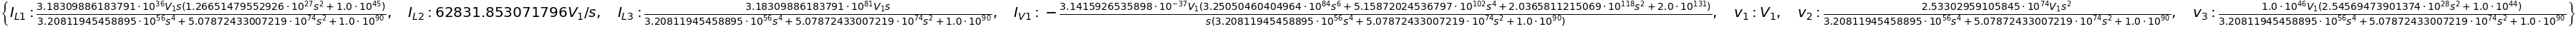

In [22]:
element_values = {L1:L1a,C1:C1a,C2:C2a,L2:L2a,L3:L3a,C3:C3a}

# find solution
u_p1 = solve(equ_p1.subs(element_values),[v1, v2, v3, I_V1, I_L1, I_L2, I_L3])
u_p1

$z_{11} = \frac {V_1}{I_1} \text{  when  } I_2=0$  

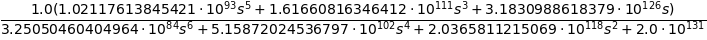

In [23]:
z11 = -u_p1[v1]/u_p1[I_V1]
z11.simplify()

$z_{21} = \frac {V_2}{I_1} \text{  when  } I_2=0$  

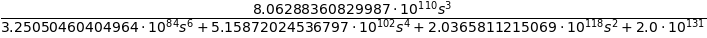

In [24]:
z21 = -u_p1[v2]/u_p1[I_V1]
z21.simplify()

## Find z12 & z22
Remove V1 from net list.

~~~
*V1 1 0 1
V2 2 0 1
L1 1 3 77.2e-6
C1 1 0 1.072e-9
C2 2 0 7.0e-9
L2 1 0 236.1e-9
L3 2 0 36.1e-9
C3 2 3 3.3e-12


[[Eq(C1*s*v1 + I_L1 + I_L2, 0)],
[Eq(-C3*s*v3 + I_L3 + I_V2 + v2*(C2*s + C3*s), 0)],
[Eq(-C3*s*v2 + C3*s*v3 - I_L1, 0)],
[Eq(v2, V2)],
[Eq(-I_L1*L1*s + v1 - v3, 0)],
[Eq(-I_L2*L2*s + v1, 0)],
[Eq(-I_L3*L3*s + v2, 0)]]

str(equ.free_symbols)
'{V2, L2, I_L2, v2, v1, C1, C3, L1, v3, I_L3, s, C2, L3, I_V2, I_L1}'
str(X)
'[v1, v2, v3, I_V2, I_L1, I_L2, I_L3]'


check P2 active

[[Eq(C1*s*v1 + I_L1 + I_L2, 0)],
[Eq(-C3*s*v3 + I_L3 + I_V2 + v2*(C2*s + C3*s), 0)],
[Eq(-C3*s*v2 + C3*s*v3 - I_L1, 0)],
[Eq(v2, V2)],
[Eq(-I_L1*L1*s + v1 - v3, 0)],
[Eq(-I_L2*L2*s + v1, 0)],
[Eq(-I_L3*L3*s + v2, 0)]]

str(equ.free_symbols)
'{V2, L2, I_L2, v2, v1, C1, C3, L1, v3, I_L3, s, C2, L3, I_V2, I_L1}'
str(X)
'[v1, v2, v3, I_V2, I_L1, I_L2, I_L3]'

~~~


In [25]:
# declare the following symbols
V2, L2, I_L2, v2, v1, C1, C3, L1, v3, I_L3, s, C2, L3, I_V2, I_L1 = symbols('V2 L2 I_L2 v2 v1 C1 C3 L1 v3 I_L3 s C2 L3 I_V2 I_L1')

# use the equations generated by nodal analysis
equ_p2 = Matrix(
    [[Eq(C1*s*v1 + I_L1 + I_L2, 0)],
    [Eq(-C3*s*v3 + I_L3 + I_V2 + v2*(C2*s + C3*s), 0)],
    [Eq(-C3*s*v2 + C3*s*v3 - I_L1, 0)],
    [Eq(v2, V2)],
    [Eq(-I_L1*L1*s + v1 - v3, 0)],
    [Eq(-I_L2*L2*s + v1, 0)],
    [Eq(-I_L3*L3*s + v2, 0)]])
equ_p2

⎡          C₁⋅s⋅v₁ + I_L1 + I_L2 = 0          ⎤
⎢                                             ⎥
⎢-C₃⋅s⋅v₃ + I_L3 + I_V2 + v₂⋅(C₂⋅s + C₃⋅s) = 0⎥
⎢                                             ⎥
⎢        -C₃⋅s⋅v₂ + C₃⋅s⋅v₃ - I_L1 = 0        ⎥
⎢                                             ⎥
⎢                   v₂ = V₂                   ⎥
⎢                                             ⎥
⎢          -I_L1⋅L₁⋅s + v₁ - v₃ = 0           ⎥
⎢                                             ⎥
⎢             -I_L2⋅L₂⋅s + v₁ = 0             ⎥
⎢                                             ⎥
⎣             -I_L3⋅L₃⋅s + v₂ = 0             ⎦

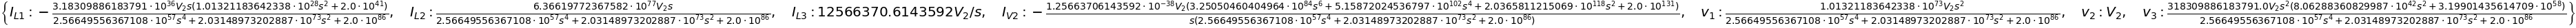

In [26]:
# find symbolic solution
u_p2 = solve(equ_p2.subs(element_values),[v1, v2, v3, I_V2, I_L1, I_L2, I_L3])
u_p2

$z_{12} = \frac {V_1}{I_2} \text{  when  } I_1=0$ 

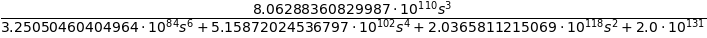

In [27]:
z12 = -u_p2[v1]/u_p2[I_V2]
z12.simplify()

$z_{22} = \frac {V_2}{I_2} \text{  when  } I_1=0$  

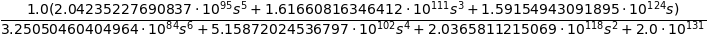

In [28]:
z22 = -u_p2[v2]/u_p2[I_V2]
z22.simplify()

In [29]:
func_z11_s = lambdify(s, z11)
func_z12_s = lambdify(s, z12) 
func_z21_s = lambdify(s, z21) 
func_z22_s = lambdify(s, z22) 

The input impedance of a two-port network is given by:

$Z_{in}=Z_{11}-\frac {Z_{12}Z_{21}} {Z_{22}+Z_{L}}$

where ZL is the impedance of the load connected to port two.

Similarly, the output impedance is given by:

$Z_{out}=Z_{22}-\frac {Z_{12}Z_{21}}{Z_{11}+Z_{S}}$


Voltage gain  
$K_v = \frac {Z_{21}Z_{L}}{\Delta _Z+Z_{11}Z_L}$

Current gain  
$K_i = \frac {-Z_{21}}{Z_{22}+Z_L}$

See table 4.2, page 137, Active Network Theory for circuit properties.

In [40]:
Zl = 50
Zs = 50

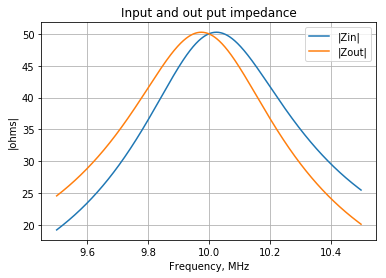

In [58]:
w = np.linspace(9.5e6*2*np.pi, 10.5e6*2*np.pi, 1000, endpoint=True)
#w = np.linspace(8e6*2*np.pi, 12e6*2*np.pi, 1000, endpoint=True)

Ki = (-func_z21_s(1j*w))/( func_z22_s(1j*w)+Zl)
Kv = (func_z21_s(1j*w)*Zl)/((func_z11_s(1j*w)*func_z22_s(1j*w) - func_z12_s(1j*w)*func_z21_s(1j*w)) + func_z11_s(1j*w)*Zl)

plt.title('Input and out put impedance')

plt.plot(w/(2*np.pi)/1e6, np.abs(func_z11_s(1j*w)-(func_z12_s(1j*w)*func_z21_s(1j*w))/(func_z22_s(1j*w)+Zl)),'-',label='|Zin|')
plt.plot(w/(2*np.pi)/1e6, np.abs(func_z22_s(1j*w)-(func_z12_s(1j*w)*func_z21_s(1j*w))/(func_z11_s(1j*w)+Zs)),'-',label='|Zout|')

plt.ylabel('|ohms|')
plt.xlabel('Frequency, MHz')
plt.legend()
plt.grid()
plt.show()

describe the plot, what do the traces mean to an engineer?

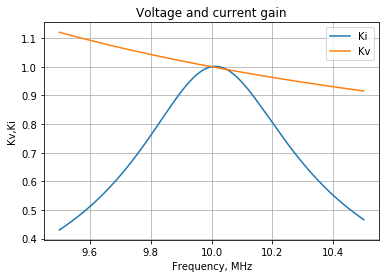

In [59]:
w = np.linspace(9.5e6*2*np.pi, 10.5e6*2*np.pi, 1000, endpoint=True)
#w = np.linspace(8e6*2*np.pi, 12e6*2*np.pi, 1000, endpoint=True)

Ki = (-func_z21_s(1j*w))/( func_z22_s(1j*w)+Zl)
Kv = (func_z21_s(1j*w)*Zl)/((func_z11_s(1j*w)*func_z22_s(1j*w) - func_z12_s(1j*w)*func_z21_s(1j*w)) + func_z11_s(1j*w)*Zl)

plt.title('Voltage and current gain')

plt.plot(w/(2*np.pi)/1e6, np.abs(Ki),'-',label='Ki')
plt.plot(w/(2*np.pi)/1e6, np.abs(Kv),'-',label='Kv')

plt.ylabel('Kv,Ki')
plt.xlabel('Frequency, MHz')
plt.legend()
plt.grid()
plt.show()

describe the plot, what do the traces mean to an engineer?

## Convert Z to S

$s_{11} = \frac {(Z_{11}-Z_o)(Z_{22}+Z_o)-Z_{12}Z_{21}} {\Delta Z}$

$s_{12} = \frac {2Z_{12}Z_o} {\Delta Z}$

$s_{21} = \frac {2Z_{21}Z_o} {\Delta Z}$

$s_{22} = \frac {(Z_{11}+Z_o)(Z_{22}-Z_o)-Z_{12}Z_{21}} {\Delta Z}$

$\Delta Z = (Z_{11}+Z_o)(Z_{22}+Z_o)-Z_{12}Z_{21}$


In [56]:
Z_o = 50 # characteristic impedance
#freq_list = np.linspace(9.5e6*2*np.pi, 10.5e6*2*np.pi, 1000, endpoint=True)
w = np.linspace(8e6*2*np.pi, 12e6*2*np.pi, 1000, endpoint=True)
s11 = np.zeros(len(w),dtype=complex)
s12 = np.zeros(len(w),dtype=complex)
s21 = np.zeros(len(w),dtype=complex)
s22 = np.zeros(len(w),dtype=complex)

for i in range(len(w)):
    del_z = (func_z11_s(1j*w[i])+Z_o)*(func_z22_s(1j*w[i])+Z_o)-func_z12_s(1j*w[i])*func_z21_s(1j*w[i])
    s11[i] = ((func_z11_s(1j*w[i])-Z_o)*(func_z22_s(1j*w[i])+Z_o)-func_z12_s(1j*w[i])*func_z21_s(1j*w[i]))/del_z
    s12[i] = (2*func_z12_s(1j*w[i])*Z_o)/del_z
    s21[i] = (2*func_z21_s(1j*w[i])*Z_o)/del_z
    s22[i] = ((func_z11_s(1j*w[i])+Z_o)*(func_z22_s(1j*w[i])-Z_o)-func_z12_s(1j*w[i])*func_z21_s(1j*w[i]))/del_z
    

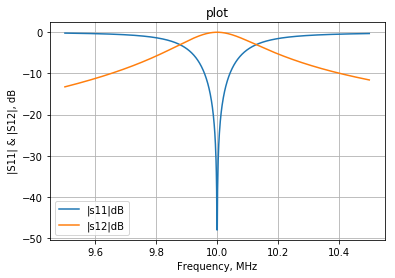

In [60]:
plt.title('plot')
plt.plot(w/(2*np.pi)/1e6, 20*np.log10(np.abs(s11)),'-',label='|s11|dB')
plt.plot(w/(2*np.pi)/1e6, 20*np.log10(np.abs(s12)),'-',label='|s12|dB')
#plt.plot(w/(2*np.pi)/1e6, 20*np.log10(np.abs(s21)),'-',label='|s21|dB')
#plt.plot(w/(2*np.pi)/1e6, 20*np.log10(np.abs(s22)),'-',label='|s22|dB')

plt.ylabel('|S11| & |S12|, dB')
plt.xlabel('Frequency, MHz')
plt.legend()
plt.grid()
plt.show()

describe the plot, what do the traces mean to an engineer?